In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt 
import helper
from sklearn.metrics import classification_report
import copy

# Recurrent Neural Network
Vì dataset này không dành cho RNN model, nên chúng tôi giả định rằng target "Traffic Situation" chính là input cho RNN model.
- Trường hợp 1: với giả định vấn đề của bài là dành cho Time-Series (như dự đoán giá cỗ phiếu, thời tiết,...), nghĩa là coi từng input "Traffic Situation" đi theo mốc thời gian (gộp các 30 input thành 1 input ý nghĩa là 30 mốc thời gian trước).
- Trường hợp 2: với giả định vấn đề của bài là dành cho Bag-Of-Words, nghĩa là gộp 30 input "Traffic Situation" thành 1 vector (đã onehot encode từng classes), coi nó như một text, sau đó dự đoán từ tiếp theo có trong đoạn text, thứ tự các từ vẫn dựa vào thời gian của cột "Time".

In [2]:
df = pd.read_csv('./TrafficTwoMonth.csv')
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal
...,...,...,...,...,...,...,...,...,...
5947,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
5948,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
5949,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
5950,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


## Trường hợp 1:

Như Dataframe bên trên đây, ta thấy rằng vì dataset này không có datetime cụ thể (thiếu tháng, năm) nên chúng tôi sẽ viết một function để generate datetime, datetime là một điều kiện để thực hiện RNN model cho time-series.\
Vì chỉ sử dụng target "Traffic Situation" làm input nên loại bỏ các features của dataset này.\
Tuy nhiên, vẫn để lại các features về thời gian để tạo ra cột index datetime, sau này sẽ xóa sau.

### Xử lý dữ liệu
Phần code tiếp theo đây dùng tạo index cho dữ liệu là cột datetime và encode các categories về dạng số (rời rạc)

In [3]:
new_df = copy.copy(df)
new_df = new_df.drop(["CarCount", "BikeCount", "BusCount", "TruckCount", "Total"], axis=1)
new_df.head()

,Time,Date,Day of the week,Traffic Situation
0,12:00:00 AM,10,Tuesday,normal
1,12:15:00 AM,10,Tuesday,normal
2,12:30:00 AM,10,Tuesday,normal
3,12:45:00 AM,10,Tuesday,normal
4,1:00:00 AM,10,Tuesday,normal


Bắt đầu tạo cột Datetime

In [4]:
new_df2 = copy.copy(new_df)
new_df2['Datetime'] = new_df2.apply(lambda x: helper.generate_datetime(x['Time'], x['Date'], x['Day of the week']), axis=1) 
new_df2.head()

,Time,Date,Day of the week,Traffic Situation,Datetime
0,12:00:00 AM,10,Tuesday,normal,2023-12-12 00:00:00
1,12:15:00 AM,10,Tuesday,normal,2023-12-12 00:15:00
2,12:30:00 AM,10,Tuesday,normal,2023-12-12 00:30:00
3,12:45:00 AM,10,Tuesday,normal,2023-12-12 00:45:00
4,1:00:00 AM,10,Tuesday,normal,2023-12-12 01:00:00


Xóa các features về thời gian, sử dụng cột datetime là index

In [5]:
new_df3 = new_df2.set_index('Datetime')
new_df4 = new_df3.drop(['Time', 'Date', 'Day of the week'], axis=1)
new_df4.sort_values(by=['Datetime'], inplace=True)

Encode Traffic Situation

In [6]:
traffic_sistuation = {
    'low': 0,
    'normal': 1,
    'high': 2, 
    'heavy':3
}


In [7]:
new_df4['Traffic Situation'] = new_df4['Traffic Situation'].replace(traffic_sistuation)
new_df4.head()

,Traffic Situation
Datetime,
2023-12-06 00:00:00,1
2023-12-06 00:00:00,1
2023-12-06 00:15:00,1
2023-12-06 00:15:00,1
2023-12-06 00:30:00,0


Plot thử 500 Traffic Situation theo thời gian

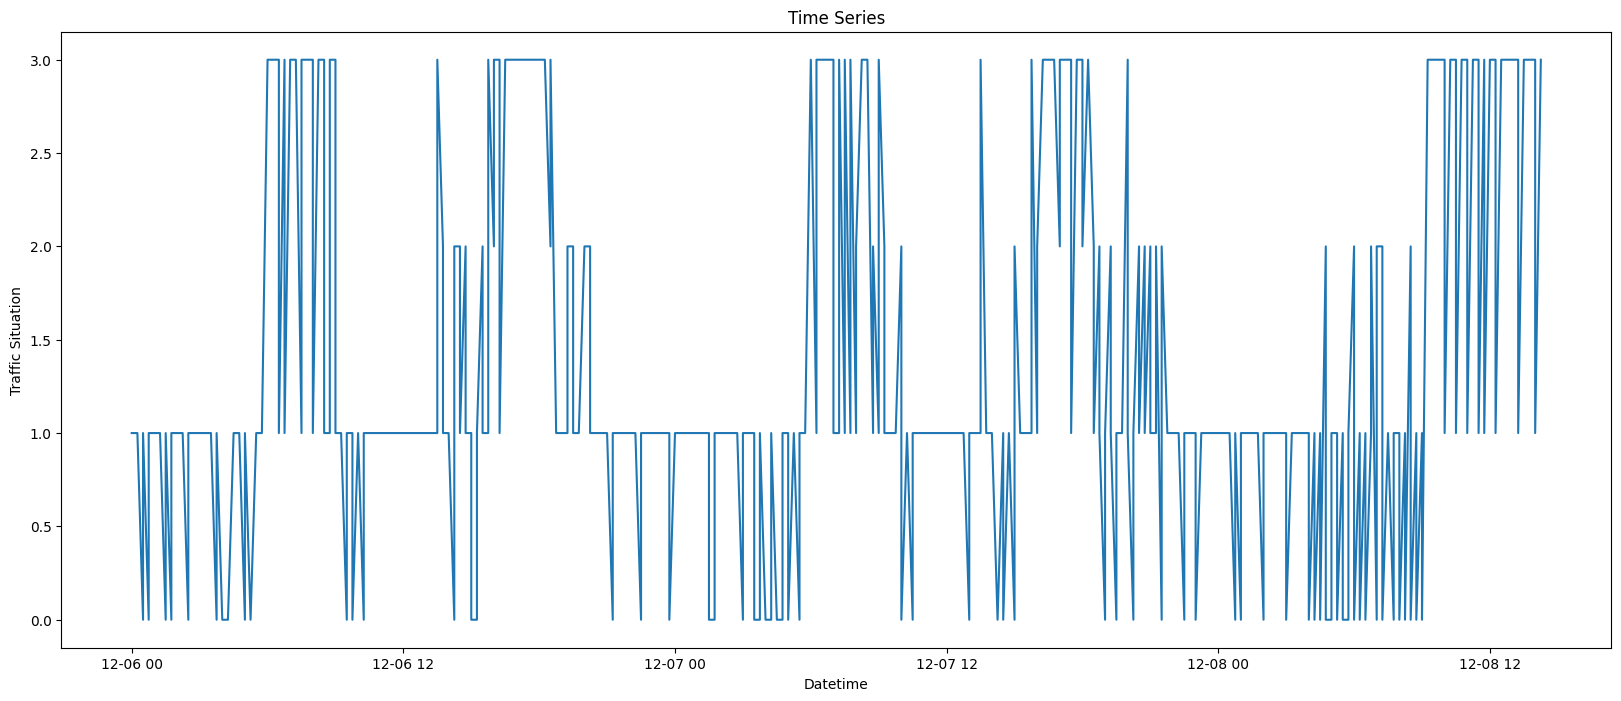

In [8]:
data500 = new_df4.iloc[:500]

plt.figure(figsize=(20,8))
plt.plot(data500)
plt.title('Time Series')
plt.xlabel('Datetime')
plt.ylabel('Traffic Situation')
plt.show()

### Split dataset
Phân chia dữ liệu để train model

Dự đoán tình trạng giao thông ở 15 tiếp theo, từ liệu 30 mốc thời gian trước (mỗi mốc thời gian là 15 phút)


In [9]:
data = copy.copy(new_df4)
data = data.values
data[:5]

array([[1],
       [1],
       [1],
       [1],
       [0]], dtype=int64)

In [10]:
timestep = 30 

X = []
y = []

n = len(data)

for i in range(n - (timestep)):
    X.append(data[i:i+timestep])
    y.append(data[i+timestep])


X = np.asanyarray(X)
y = np.asanyarray(y)


index_test = 5000 # tập test bắt đầu từ index 5000
X_train = X[:index_test,:,:]
X_test = X[index_test:,:,:]
y_train = y[:index_test]    
y_test= y[index_test:]   

In [11]:
print(X_train.shape)
print(y_train.shape)

(5000, 30, 1)
(5000, 1)


### Xây dựng model

In [12]:
model = keras.models.Sequential([
    layers.LSTM(32, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    layers.LSTM(32, activation='relu'),
    layers.Dense(1)
])

In [13]:
model.compile(optimizer='adam', loss='mse', metrics='MAE')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train RNN model

In [14]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
125/125 [==============================] - 4s 14ms/step - loss: 1.0622 - MAE: 0.7411 - val_loss: 0.5533 - val_MAE: 0.5202
Epoch 2/20
125/125 [==============================] - 2s 12ms/step - loss: 0.5364 - MAE: 0.5192 - val_loss: 0.5083 - val_MAE: 0.4911
Epoch 3/20
125/125 [==============================] - 2s 12ms/step - loss: 0.5226 - MAE: 0.5174 - val_loss: 0.5521 - val_MAE: 0.5217
Epoch 4/20
125/125 [==============================] - 2s 12ms/step - loss: 0.5100 - MAE: 0.5113 - val_loss: 0.4915 - val_MAE: 0.4856
Epoch 5/20
125/125 [==============================] - 2s 12ms/step - loss: 0.5129 - MAE: 0.5175 - val_loss: 0.4992 - val_MAE: 0.4868
Epoch 6/20
125/125 [==============================] - 2s 12ms/step - loss: 0.5053 - MAE: 0.5133 - val_loss: 0.4953 - val_MAE: 0.5072
Epoch 7/20
125/125 [==============================] - 1s 12ms/step - loss: 0.5020 - MAE: 0.5131 - val_loss: 0.4964 - val_MAE: 0.4905
Epoch 8/20
125/125 [==============================] - 2s 13ms/step - 

Plot biểu đồ quan hệ training loss, validation loss

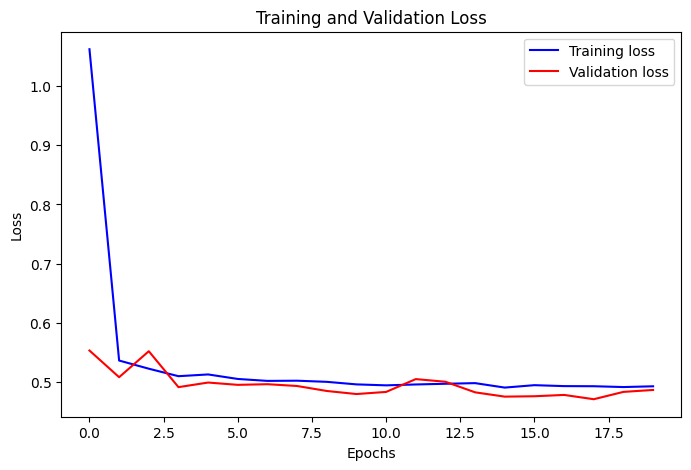

In [15]:
helper.plot_Loss_Val(history)

Predict

In [16]:
y_pred = model.predict(X_test)
y_pred[:5]

29/29 [==============================] - 0s 5ms/step


array([[1.1077266],
       [1.0391756],
       [1.2092719],
       [1.4551   ],
       [1.5158294]], dtype=float32)

In [17]:
print(y_pred[:5])
print(y_test[:5])

[[1.1077266]
 [1.0391756]
 [1.2092719]
 [1.4551   ]
 [1.5158294]]
[[0]
 [2]
 [2]
 [1]
 [0]]


Plot biểu đồ giữ giá trị thật sự và dự đoán

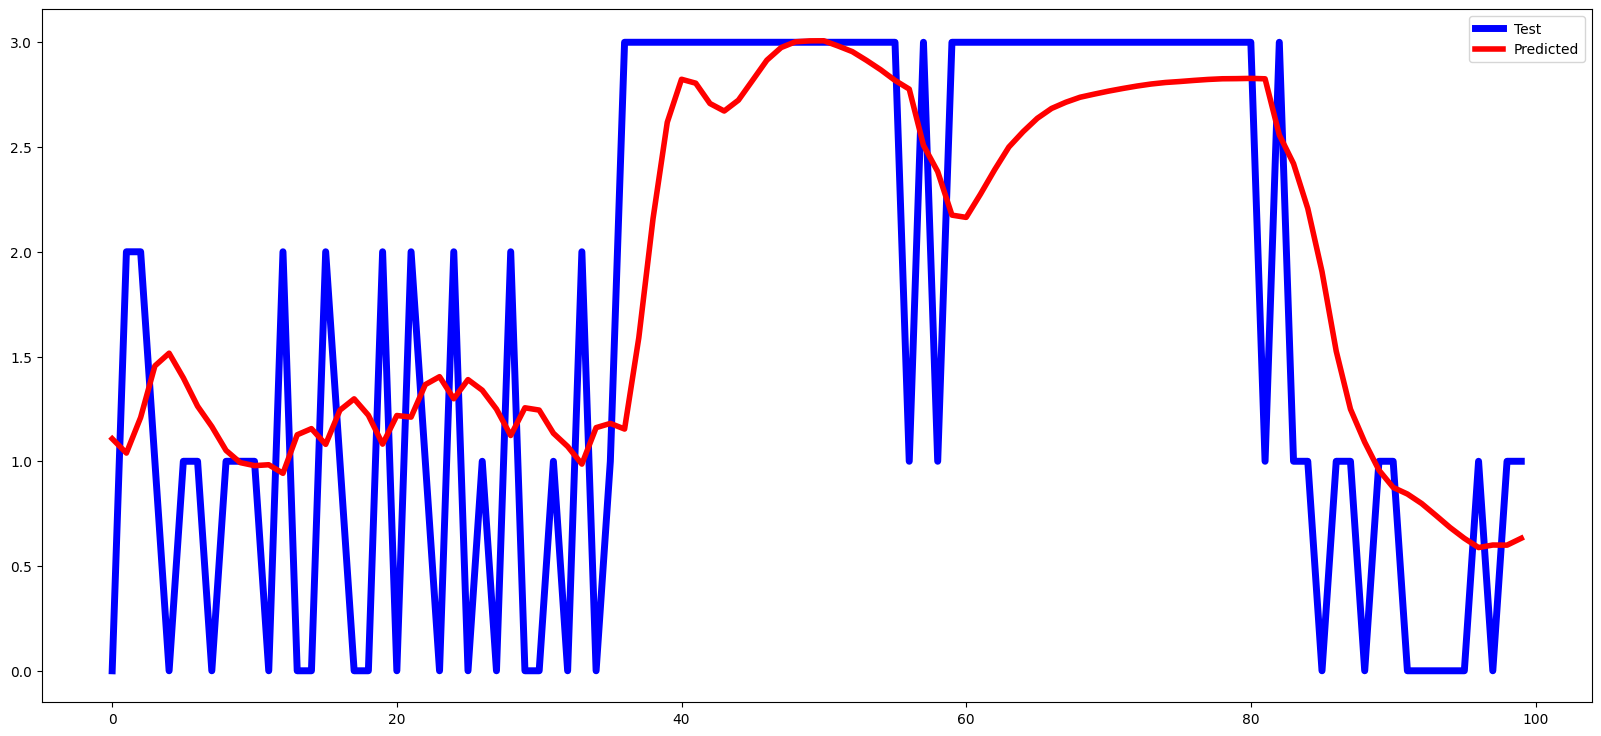

In [18]:
plt.figure(figsize=(20,9))
plt.plot(y_test[:100] , 'blue', linewidth=5)
plt.plot(y_pred[:100],'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

0.4002169197396963


#### Trường hợp 2:

In [19]:
new_df = copy.copy(df)
new_df = new_df.drop(["CarCount", "BikeCount", "BusCount", "TruckCount", "Total"], axis=1)
new_df2 = copy.copy(new_df)
new_df2['Datetime'] = new_df2.apply(lambda x: helper.generate_datetime(x['Time'], x['Date'], x['Day of the week']), axis=1) 
new_df3 = new_df2.set_index('Datetime')
new_df4 = new_df3.drop(['Time', 'Date', 'Day of the week'], axis=1)
new_df4['Traffic Situation'] = new_df4['Traffic Situation'].replace(traffic_sistuation)
new_df4

,Traffic Situation
Datetime,
2023-12-12 00:00:00,1
2023-12-12 00:15:00,1
2023-12-12 00:30:00,1
2023-12-12 00:45:00,1
2023-12-12 01:00:00,1
...,...
2023-12-14 22:45:00,1
2023-12-14 23:00:00,1
2023-12-14 23:15:00,1


In [20]:
data = pd.get_dummies(new_df4.to_numpy().reshape(-1), dtype=int).values
data

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

Lấy input là một vector có kích thước là 30

In [21]:
timestep = 30

X = []
y = []

n = len(data)

for i in range(n - (timestep)):
    X.append(data[i:i+timestep])
    y.append(data[i+timestep])

X = np.asanyarray(X)
y = np.asanyarray(y)


index_test = 5000
X_train = X[:index_test,:,:]
X_test = X[index_test:,:,:]
y_train = y[:index_test]    
y_test= y[index_test:]  
y_test= y[index_test:]  

In [22]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)

(5000, 30, 4)
(5000, 4)
(922, 4)


Train RNN model

In [23]:
model = keras.models.Sequential([
    layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(4, activation='softmax')
])

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                11000     
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 11204 (43.77 KB)
Trainable params: 11204 (43.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20


125/125 [==============================] - 3s 12ms/step - loss: 1.0132 - accuracy: 0.6255 - val_loss: 1.0812 - val_accuracy: 0.5940
Epoch 2/20
125/125 [==============================] - 1s 10ms/step - loss: 0.8677 - accuracy: 0.6880 - val_loss: 0.9277 - val_accuracy: 0.6680
Epoch 3/20
125/125 [==============================] - 1s 9ms/step - loss: 0.8134 - accuracy: 0.7097 - val_loss: 0.9777 - val_accuracy: 0.6630
Epoch 4/20
125/125 [==============================] - 1s 9ms/step - loss: 0.7821 - accuracy: 0.7175 - val_loss: 0.9457 - val_accuracy: 0.6810
Epoch 5/20
125/125 [==============================] - 1s 10ms/step - loss: 0.7755 - accuracy: 0.7180 - val_loss: 0.9380 - val_accuracy: 0.6460
Epoch 6/20
125/125 [==============================] - 1s 9ms/step - loss: 0.7663 - accuracy: 0.7178 - val_loss: 0.9025 - val_accuracy: 0.6640
Epoch 7/20
125/125 [==============================] - 1s 8ms/step - loss: 0.7577 - accuracy: 0.7195 - val_loss: 0.8876 - val_accuracy: 0.6700
Epoch 8/20
125

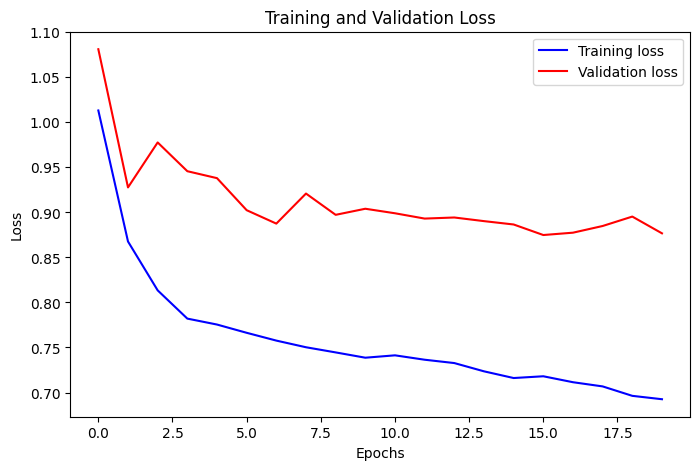

In [26]:
helper.plot_Loss_Val(history)

### Predict

In [27]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)

29/29 [==============================] - 0s 3ms/step


In [28]:
print(y_pred[:5])
print(y_test[:5])

[1 1 1 1 1]
[1 1 1 1 1]


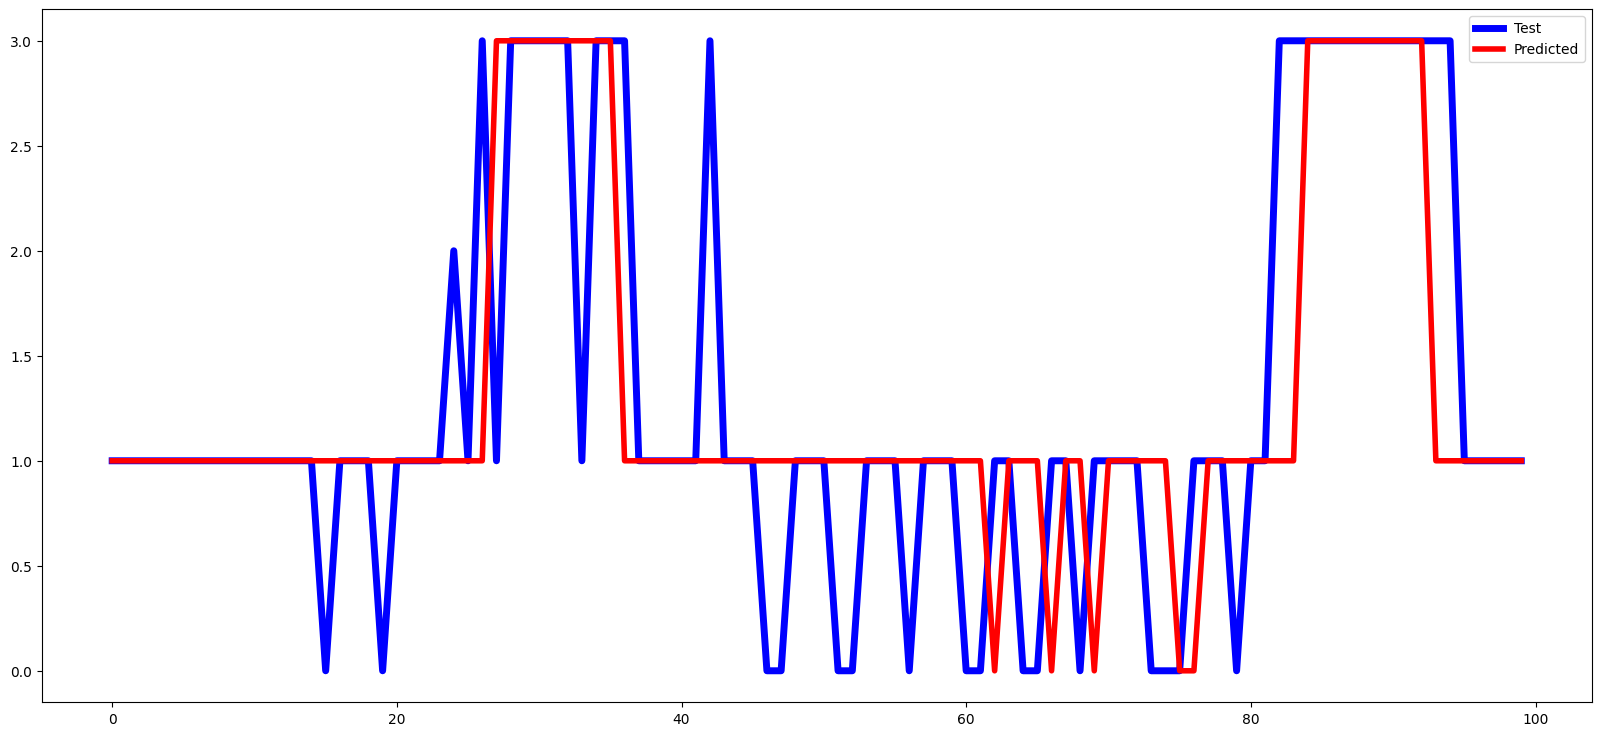

In [29]:
plt.figure(figsize=(20,9))
plt.plot(y_test[:100] , 'blue', linewidth=5)
plt.plot(y_pred[:100],'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

Kết quả dự đoán với giá trị thật

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.28      0.39       151
           1       0.67      0.93      0.78       492
           2       0.00      0.00      0.00        62
           3       0.85      0.66      0.74       217

    accuracy                           0.70       922
   macro avg       0.54      0.47      0.48       922
weighted avg       0.66      0.70      0.65       922



c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

#### Kết luận:
Vì dataset không phù hợp cho RNN model nên dường như model dự đoán không chính xác. \
Nếu xét xem về phần giả định tốt hơn khi nhìn vào biểu đồ thì trường hợp 2 dự đoán chính xác hơn.